# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [ ]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [ ]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

Start by using the code from class as a template. We have to find new initial values for Co, Bo and No. We will then only do this for the first 15m. after 15m we need to adjust...

1. to solve the portion before 15m, we need to use the Streeter-Phelps Equation (insert equation). We will omit P R and Sb in this case because thevalues are not provided. We next need to solve for Co, Bo and No. This can be done by using the Cmix equation from class Cmix = (QC1 + QC2) / Q1+Q2. This can be used to solve all 3 variables, and gives 7.27, 9.09 and 7.72 for Co, Bo and No respectively. Plugging in these values for any distance before 15m will provide the correct solution
2. For portions after the second stream at 15m, we need to adjust the equation and the 'initial' values. in alpha 1 2 and 3 x needs to be changed to x-15, because we have shifted the 'start' to 15m downstream. Next we need new C N and B values. We need to repeat the Cmix eauation, but using C(15), B(15) and N(15) as our initial river values, along with the provided stream 2 values. 
3. To implement the code, we modified the code from lecture. The values are set and calculated based on river position.


::Here I use C to mean C B and N::
also, Q should be changed into L/d, which is just x1000. That means we have 10^8, 10^7 and 1.5*10^7 L/d for each

First, solve our C0mix, C15 and C15mix values based on treatment options:
how:
 1. write a function that will calculate Cmix given flow 1 and 2 and C 1 and 2.
 2. run this function to find C0mix.
 3. then use the streeter phelps to find C15
 4. then use the function again to find C15mix

 This will allow us to adjust our C values every time we want to check a new treatment option

In [34]:
#Calculate the mixture concentration
function mixture(Q1,Q2,C1,C2)
    Cfinal = (Q1*C1 + Q2*C2)/(Q1+Q2)
    return Cfinal
end

#solve the concentration at x location
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

# set river properties
Qr = 10^8;
Qs1 = 10^7;
Qs2 = 1.5*10^7;
#set the given concentrations, THIS IS WHAT WE WILL CHANGE
Cr = 7.5;
Cs1 = 5;
Cs2 = 5;

Br = 5;
Bs1 = 50;
Bs2 = 45;

Nr = 5;
Ns1 = 35;
Ns2 = 45;

#rates 
ka = 0.55;
kc = 0.35;
kn = 0.25;

#solve the mix concentrations for location x=0;
C0 = mixture(Qr,Qs1,Cr,Cs1)
B0 = mixture(Qr,Qs1,Br,Bs1)
N0 = mixture(Qr,Qs1, Nr, Ns1)

#Cs is 
Cs = 10
U = 6

#FIND Cs at 15
x = 15

# evaluate model over all x's
# this uses broadcasting
# and save the values as the river concentration at 15
(C15,B15,N15) = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(x)

#now calculate the mix concentrations at 15 for post 15 data
 C15mix = mixture(Qr,Qs1,C15,Cs2)
 B15mix = mixture(Qr,Qs1,B15,Bs2)
 N15mix = mixture(Qr,Qs1,N15,Ns2)
 






C15mix = mixture(Qr, Qs1, C15, Cs2) = 4.957134202351118


4.957134202351118

The above code shows us the values of C B and N at 15m as (4.95, 4.87 and 3.22).

Now we can use these values for any position after 15m.

We will also find the minimum value of dissolved oxygen by using the minimum function of the array of C values that we make.

minimum(C) = 3.53502076386036


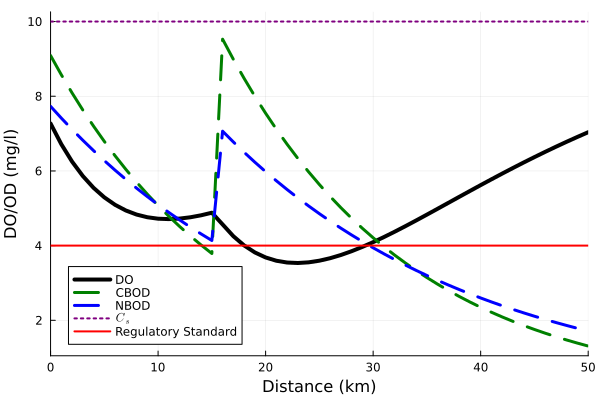

In [28]:
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    # set river properties
    ka = 0.55
    kc = 0.35
    kn = 0.25
 
    Cs = 10
    U = 6
    #change the 'initial' properties based on position
        if x<=15
            #solved on paper
            C0 = 7.27
            B0 = 9.09
            N0 = 7.73
            B = B0 * exp(-kc * x / U)
            N = N0 * exp(-kn * x / U)
            α1 = exp(-ka * x / U)
            α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
            α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
            C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
        else #after the second input
            #solved on paper 
            C0 = 4.96
            B0 = 10.10
            N0 = 7.365

            B = B0 * exp(-kc * (x-15) / U)
            N = N0 * exp(-kn * (x-15) / U)
            #we can get rid of B and N later, we really only need C
            α1 = exp(-ka * (x-15) / U)
            α2 = (kc/(ka-kc)) * (exp.(-kc * (x-15) / U) - exp(-ka * (x-15) / U))
            α3 = (kn/(ka-kn)) * (exp(-kn * (x-15) / U) - exp(-ka * (x-15) / U))
            C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
        end

    
    return (C, B, N)
end  

#Now we can run through all x
x = 0:50

# evaluate model over all x's
# this uses broadcasting
do_out = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(x)
# unpack outputs into individual arrays for C, B, and N
# this uses comprehensions to pull out the relevant components 
#of the tuples that our function outputs
C = [d[1] for d in do_out]
B = [d[2] for d in do_out]
N = [d[3] for d in do_out]

#find the minimum DO by using the min function on C after building the array
@show minimum(C)

# plot outputs
p1 = plot(; ylabel="DO/OD (mg/l)", xlabel="Distance (km)")
plot!(p1, x, C, color=:black, linewidth=4, label="DO")
plot!(p1, x, B, color=:green, label="CBOD", linestyle=:dash, linewidth=3)
plot!(p1, x, N, color=:blue, label="NBOD", linestyle=:dash, linewidth=3)
# plot Cs, which is a constant value 
plot!(p1, x, Cs * ones(length(x)), color=:purple, label=L"C_s", linestyle=:dot, linewidth=2)

#change regulatory standard to 4
hline!([4], color=:red, linewidth=2, label="Regulatory Standard")
xaxis!((0, 50))



In [ ]:
The minimum DO value is 3.54 mg/L, and it occurs 

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [ ]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

We can plot the aerosol and non-aerosol forcings below.

In [ ]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.